이제 경제 위기 예측의 핵심 재료인 **10년물 국채 금리(GS10)**와 **2년물 국채 금리(GS2)**를 데이터베이스에서 꺼내와 요리해 보겠습니다.

🕵️‍♂️ 분석 목표: "장단기 금리차(Spread)" 만들기

10년물 (GS10): "미래(10년 뒤) 경제가 좋을까?" (시장 심리 반영)

2년물 (GS2): "지금 연준이 금리를 올리나?" (통화 정책 반영)

정상: 10년물이 2년물보다 이자가 높아야 합니다. (기간이 기니까 위험 수당을 더 줌)

비정상 (위기 신호): 2년물 이자가 더 비싸지는 현상 (역전, Inversion). 이게 발생하면 "단기 자금 사정이 어렵다"는 뜻이고, 곧 침체가 온다는 강력한 신호입니다.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# 1. DB 연결 (어제와 동일)
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)
# --- 이 부분을 추가합니다 ---
pd.set_option('display.max_rows', None)      # 모든 행을 표시
pd.set_option('display.max_columns', None)   # 모든 열을 표시 (여기서는 1개 열만 있지만)
pd.set_option('display.max_colwidth', None)  # 열 내용의 최대 너비를 무제한으로 설정
# -------------------------
print("✅ 장단기 금리차 분석 준비 완료!")

✅ 장단기 금리차 분석 준비 완료!


In [18]:
# DB에 어떤 경제 지표들이 저장되어 있는지 명단을 뽑아봅니다.
query_check = "SELECT DISTINCT indicator_symbol FROM macro_time_series;"
df_symbols = pd.read_sql(query_check, engine)

print("📜 데이터베이스에 저장된 지표 목록:")
print(df_symbols)

📜 데이터베이스에 저장된 지표 목록:
                                          indicator_symbol
0                                                  BOPGSTB
1                                           CAPUTLB50001SQ
2                                                  CIVPART
3                                                 CPIAUCSL
4                                                CSUSHPISA
5                                             DCOILBRENTEU
6                                               DCOILWTICO
7                                                  DEXCHUS
8                                                  DEXUSEU
9                                                 DTWEXBGS
10                                                FEDFUNDS
11                                                     GDP
12                                                   GDPC1
13                                                   HOUST
14                                                    ICSA
15                                 

In [40]:
# 1. 10년물 국채 금리 가져오기 (AS 별칭 쓰지 않고 원본 컬럼명 그대로 가져옵니다)
# 만약 데이터가 없으면 빈 표가 올 수 있으니 확인해야 합니다.
query_10y = """
SELECT date_time, value
FROM macro_time_series
WHERE indicator_symbol = 'UNITED_STATES_GOVERNMENT_BOND_10Y'
ORDER BY date_time ASC;
"""
df_10y = pd.read_sql(query_10y, engine)

# 🕵️‍♂️ [진단] 도대체 컬럼 이름이 뭘로 들어왔는지 출력해봅니다.
print("🧐 df_10y의 실제 컬럼 이름들:", df_10y.columns.tolist())

# 2. 기준금리 가져오기
query_fed = """
SELECT date_time, value
FROM macro_time_series
WHERE indicator_symbol = 'FEDFUNDS'
ORDER BY date_time ASC;
"""
df_fed = pd.read_sql(query_fed, engine)

# 3. [강제 개명] 컬럼 이름을 우리가 원하는 대로 바꿉니다.
# date_time -> trade_date
# value -> us10y / fed_rate
df_10y = df_10y.rename(columns={'date_time': 'trade_date', 'value': 'us10y'})
df_fed = df_fed.rename(columns={'date_time': 'trade_date', 'value': 'fed_rate'})

# 4. 데이터 전처리 (이제 trade_date가 확실히 있습니다)
if not df_10y.empty and not df_fed.empty:
    df_10y['trade_date'] = pd.to_datetime(df_10y['trade_date'], utc=True)
    df_fed['trade_date'] = pd.to_datetime(df_fed['trade_date'], utc=True)

    # 인덱스 설정 및 월별 리샘플링
    df_10y = df_10y.set_index('trade_date').resample('ME').last()
    df_fed = df_fed.set_index('trade_date').resample('ME').last()

    # 합치기
    df_spread = pd.merge(df_10y, df_fed, left_index=True, right_index=True, how='inner')

    # 금리차 계산
    df_spread['spread'] = df_spread['us10y'] - df_spread['fed_rate']

    print("-" * 50)
    print("✅ (강제 개명 완료) 장단기 금리차 데이터:")
    print(df_spread.tail(10))
else:
    print("🚨 데이터가 비어있습니다! 쿼리 결과가 0건입니다.")

🧐 df_10y의 실제 컬럼 이름들: ['date_time', 'value']
--------------------------------------------------
✅ (강제 개명 완료) 장단기 금리차 데이터:
                           us10y  fed_rate  spread
trade_date                                        
2024-11-30 00:00:00+00:00      4         5      -1
2024-12-31 00:00:00+00:00      5         4       1
2025-01-31 00:00:00+00:00      5         4       1
2025-02-28 00:00:00+00:00      4         4       0
2025-03-31 00:00:00+00:00      4         4       0
2025-04-30 00:00:00+00:00      4         4       0
2025-05-31 00:00:00+00:00      4         4       0
2025-06-30 00:00:00+00:00      4         4       0
2025-07-31 00:00:00+00:00      4         4       0
2025-08-31 00:00:00+00:00      4         4       0


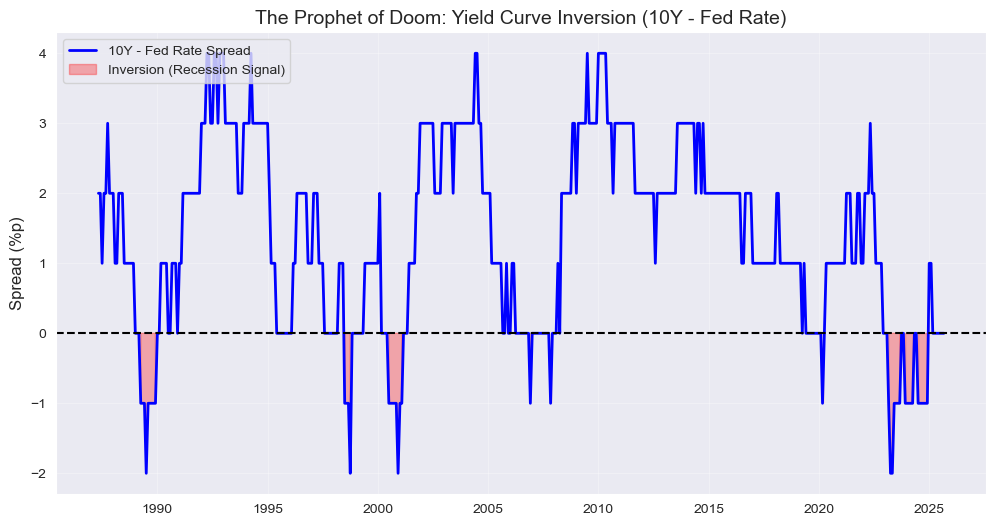

In [43]:
# 1. 그래프 그리기 준비
fig, ax = plt.subplots(figsize=(12, 6))

# 2. 장단기 금리차 선 그리기 (파란선)
# 🚨 수정: 이미 DatetimeIndex이므로 .to_timestamp()를 지우고 바로 씁니다!
plot_index = df_spread.index

ax.plot(plot_index, df_spread['spread'], color='blue', linewidth=2, label='10Y - Fed Rate Spread')

# 3. 🚨 위기 경보: 0 밑으로 떨어진 구간 색칠하기 (Danger Zone)
# fill_between: 특정 조건(y < 0)일 때 영역을 채워줍니다.
ax.fill_between(plot_index, df_spread['spread'], 0,
                where=(df_spread['spread'] < 0),
                color='red', alpha=0.3, label='Inversion (Recession Signal)')

# 4. 기준선 (0)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)

# 5. 꾸미기
ax.set_title("The Prophet of Doom: Yield Curve Inversion (10Y - Fed Rate)", fontsize=14)
ax.set_ylabel("Spread (%p)", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.show()

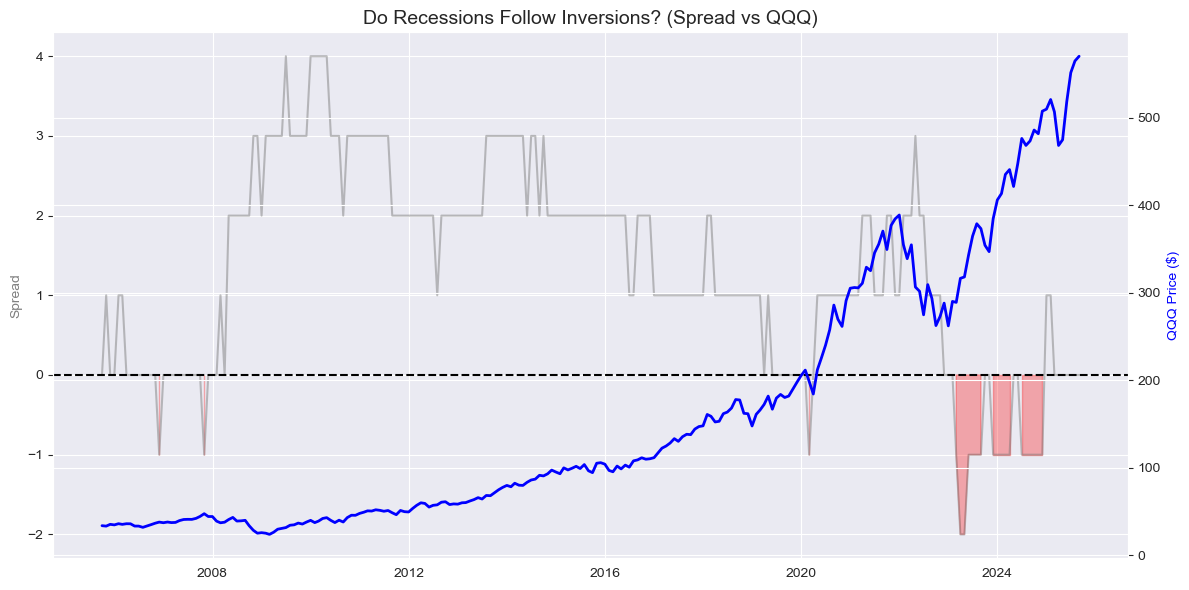

In [45]:
# 1. QQQ 데이터 다시 불러오기 (이 노트북엔 아직 없으니까요!)
query_qqq = """
SELECT trade_date::text AS trade_date, close_price
FROM market_price_daily
WHERE symbol = 'QQQ'
ORDER BY trade_date ASC;
"""
df_qqq = pd.read_sql(query_qqq, engine)

# 2. 날짜 변환 및 월별 데이터로 맞추기
df_qqq['trade_date'] = pd.to_datetime(df_qqq['trade_date'], utc=True)
df_qqq = df_qqq.set_index('trade_date').resample('ME').last()

# 3. 금리차 데이터와 합치기
df_final = pd.merge(df_spread, df_qqq, left_index=True, right_index=True, how='inner')

# --- 그래프 그리기 ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 왼쪽 축: 장단기 금리차 (빨간 웅덩이)
plot_index = df_final.index
ax1.plot(plot_index, df_final['spread'], color='gray', alpha=0.5, label='Yield Spread (10Y - Fed)')
ax1.fill_between(plot_index, df_final['spread'], 0,
                 where=(df_final['spread'] < 0),
                 color='red', alpha=0.3, label='Recession Signal')
ax1.set_ylabel('Spread', color='gray')
ax1.axhline(0, color='black', linestyle='--')

# 오른쪽 축: QQQ 주가 (파란선)
ax2 = ax1.twinx()
ax2.plot(plot_index, df_final['close_price'], color='blue', linewidth=2, label='QQQ Price')
ax2.set_ylabel('QQQ Price ($)', color='blue')

# 제목 및 범례
plt.title("Do Recessions Follow Inversions? (Spread vs QQQ)", fontsize=14)
fig.tight_layout()
plt.show()